In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/deeplearning/datafordoan.zip -d .

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ./datafordemo/test/bike/022.jpg  
  inflating: ./datafordemo/test/bike/023.jpg  
  inflating: ./datafordemo/test/bike/024.jpg  
  inflating: ./datafordemo/test/bike/025.jpg  
  inflating: ./datafordemo/test/bike/026.jpg  
  inflating: ./datafordemo/test/bike/027.jpg  
  inflating: ./datafordemo/test/bike/028.jpg  
  inflating: ./datafordemo/test/bike/029.jpg  
  inflating: ./datafordemo/test/bike/030.jpg  
  inflating: ./datafordemo/test/bike/031.jpg  
  inflating: ./datafordemo/test/bike/032.jpg  
  inflating: ./datafordemo/test/bike/033.jpg  
  inflating: ./datafordemo/test/bike/034.jpg  
  inflating: ./datafordemo/test/bike/035.jpg  
  inflating: ./datafordemo/test/bike/036.jpg  
  inflating: ./datafordemo/test/bike/037.jpg  
  inflating: ./datafordemo/test/bike/038.jpg  
  inflating: ./datafordemo/test/bike/039.jpg  
  inflating: ./datafordemo/test/bike/040.jpg  
  inflating: ./datafordemo/test/bike/041.jpg  
  i

In [4]:
# Đường dẫn dữ liệu
BASE_PATH = "/content/datafordemo"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VALID_PATH = os.path.join(BASE_PATH, "valid")
TEST_PATH = os.path.join(BASE_PATH, "test")
# Kích thước
img_height, img_width = 224, 224
batch_size = 32

In [5]:
# Tạo các data generators cho training, validation và test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3502 images belonging to 5 classes.
Found 1001 images belonging to 5 classes.
Found 502 images belonging to 5 classes.


In [6]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print(class_names)

['bike', 'cars', 'cats', 'dogs', 'human']


In [7]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(img_height,img_width,3),
                                                  pooling='avg', classes=5,
                                                  weights='imagenet')
#đóng băng các layers của mô hình resnet50
for layer in pretrained_model.layers:
  layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

94765736/94765736 [==============================] - 5s 0us/step


In [8]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
epochs=30
history = resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

Epoch 1/30
110/110 [==============================] - 83s 634ms/step - loss: 1.5685 - accuracy: 0.3224 - val_loss: 1.3629 - val_accuracy: 0.4256
Epoch 2/30
110/110 [==============================] - 69s 624ms/step - loss: 1.3730 - accuracy: 0.4395 - val_loss: 1.2476 - val_accuracy: 0.4765
Epoch 3/30
110/110 [==============================] - 67s 611ms/step - loss: 1.3064 - accuracy: 0.4649 - val_loss: 1.1585 - val_accuracy: 0.5355
Epoch 4/30
110/110 [==============================] - 69s 624ms/step - loss: 1.2503 - accuracy: 0.4860 - val_loss: 1.0695 - val_accuracy: 0.5854
Epoch 5/30
110/110 [==============================] - 68s 615ms/step - loss: 1.2143 - accuracy: 0.5097 - val_loss: 1.0497 - val_accuracy: 0.6234
Epoch 6/30
110/110 [==============================] - 68s 616ms/step - loss: 1.1774 - accuracy: 0.5277 - val_loss: 1.0950 - val_accuracy: 0.5974
Epoch 7/30
110/110 [==============================] - 69s 630ms/step - loss: 1.1279 - accuracy: 0.5477 - val_loss: 1.0513 - val_ac

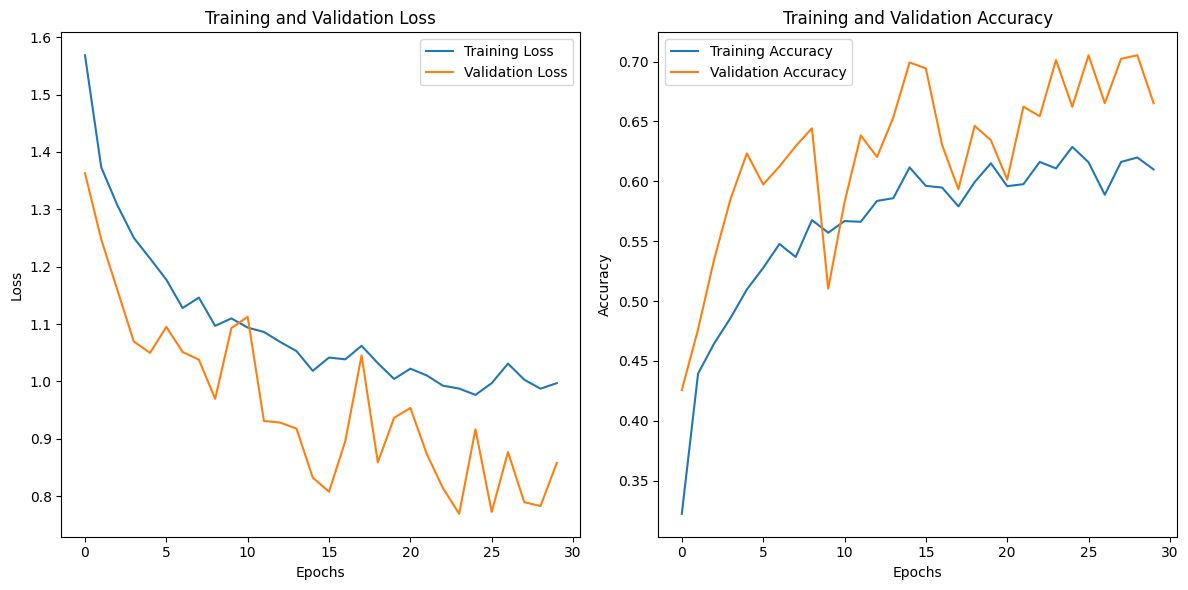

In [10]:
# Vẽ biểu đồ huấn luyện
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Đánh giá mô hình trên tập test
test_loss, test_accuracy = resnet_model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.3f}")

16/16 [==============================] - 6s 331ms/step - loss: 0.9711 - accuracy: 0.6454
Test accuracy: 0.645
